In [20]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torchinfo import summary
from torch.autograd import Variable
from collections import OrderedDict

import os
import glob
import tqdm
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses # https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb


## Model: Deep Dense Network

**Notation:**

- $\textbf{x}_0$ is generic image prior to any operations
- $H_l(\cdot)$ is the non-linear transformation function applied at layer $l = 1, \ldots L$, where $L$ is the total number of layers

**Standard network Connectivity**
$$
\textbf{x}_l = H_l(\textbf{x}_{l-1})
$$ 

**ResNet Connectivity**
$$
\textbf{x}_l = H_l(\textbf{x}_{l-1}) + \textbf{x}_{l-1}
$$

**DenseNet Connectivity**

$$
\textbf{x}_l = H_l([\textbf{x}_0, \ldots, \textbf{x}_{l-1}])
$$

Suppose each $H_l(\cdot)$ produces $k$ feature maps, $H_l(\cdot)$ has  $k_0 + k \times k(l - 1)$ input feature maps, where

- $k_0$ is the number of channels in input layer
- $k$ is the network **growth rate**
- $\implies$ each layers adds $k$ new feature maps




**Initiall Layer** Initial layer in every version consists of 
- $7 \times 7$ Convolution Layer with stride 2 and $3\times 3$ zero-padding 
- ReLU activatio
- $3 \times 3$ Pooling Layer with stride 2 and $1 \times 1 $ zero-padding 

**Dense Block** After Initial Layer Dense Block follows
- Dense Block consists of several Dense Layers

**Dense Layer** Each Dense Layer consists of:
1. Batch Normalisation $\to$ ReLu $\to$ $1 \times 1$ Conv
2. Batch Normalisation $\to$ ReLu $\to$ $3 \times 3$ Conv with $1\times 1$ zero-paddind to preserve size

**Bottleneck Layers** 
- Bottleneck layers are reduce input feature size

**Transition Layers**
- Dense Blocks are connected through Transition Layers
- Batch normalization layer  $\to 1 \times 1 $ conv $\to 2 \times 2$ average pooling layer

**Compression** 
- Compression is a way to reduce number of features during Transition Layer


## Implementation

- Original Paper: [https://github.com/liuzhuang13/DenseNet]

- Author's PyTorch Implementation [https://github.com/gpleiss/efficient_densenet_pytorch]

In [21]:
# I use M1 backend -- change for cuda if M1 is not available
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE = 256

In [22]:
data_dir = './dataset'
norm_means = (0.5, 0.5, 0.5)
norm_stds = (0.5, 0.5, 0.5)
data_transforms = {
    'train':  transforms.Compose([
        transforms.TrivialAugmentWide(), # crucial part
        transforms.ToTensor(),
        transforms.Normalize(norm_means, norm_stds)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(norm_means, norm_stds)
    ])}


train_dataset = ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

In [23]:
train_loader =  DataLoader(train_dataset, batch_size = BATCH_SIZE,
                           shuffle = True) 
val_loader =  DataLoader(val_dataset, batch_size = BATCH_SIZE,
                           shuffle = False) 
N_CLASSES = len(train_loader.dataset.classes)
print(f'Classes: {N_CLASSES}')

dataloaders = {'train': train_loader, 'val': val_loader}

Classes: 200


### Model Architecture

In [24]:
def bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output
    return bn_function

In [25]:
class DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        '''
        function to compute 1 layer consisting of 1 bottleneck layer and 1 convolution layer
        
            num_input_features - ...
            growth_rate -- how many new features each dense layer introduces
            bn_size     -- number of bottleneck layers
        '''
        super(DenseLayer, self).__init__()
        # Used for Bottleneck and for the 1st Stage of DenseLayer
        self.add_module('norm1', nn.BatchNorm2d(
                                            num_features = num_input_features))
        self.add_module('relu1', nn.LeakyReLU(
                                            inplace=True, negative_slope = 0.02))
        self.add_module('conv1', nn.Conv2d(
                                            in_channels = num_input_features, 
                                            out_channels = bn_size * growth_rate,
                                            kernel_size = (1, 1), stride = 1, 
                                            bias = False))
        # Stage 2 
        self.add_module('norm2', nn.BatchNorm2d(
                                            num_features = bn_size * growth_rate))
        self.add_module('relu2', nn.LeakyReLU(
                                            inplace=True, negative_slope = 0.02))
        self.add_module('conv2', nn.Conv2d(
                                            in_channels = bn_size * growth_rate, 
                                            out_channels = growth_rate,
                                            kernel_size = (3,3), stride = 1, padding = (1, 1), 
                                            bias = False))
        self.drop_rate = drop_rate

        
    def forward(self, *prev_features):
        bn_function = bn_function_factory(self.norm1, self.relu1, self.conv1)
        bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features

In [26]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        '''
        Dense Block is collection of layers
        
            num_layers -- how many layers to stack
            num_input_features - ...
            bn_size - number of bottleneck layers
            growth_rate - how many new features each dense layer introduces
        '''
        super(DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = DenseLayer(
                    num_input_features = num_input_features + i * growth_rate, 
                    growth_rate = growth_rate, 
                    bn_size = bn_size, 
                    drop_rate = drop_rate
            )
            self.add_module(f'denselayer{i+1}d', layer)
    
    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)

In [27]:
class Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(
                                    num_features = num_input_features))
        self.add_module('relu', nn.LeakyReLU(
                                    inplace = True, negative_slope = 0.02))
        self.add_module('conv', nn.Conv2d(
                                    in_channels = num_input_features, 
                                    out_channels = num_output_features,
                                    kernel_size = (1,1), stride = 1, 
                                    bias = False))
        self.add_module('pool', nn.AvgPool2d(
                                    kernel_size = (2,2), stride = 2))
    

In [28]:
class DenseNet(nn.Module):
    
    def __init__(self, growth_rate, block_config,
                 compression, num_init_features,  
                 bn_size, drop_rate, num_classes):
        super(DenseNet, self).__init__()
        
        # Initial Layer
        self.features = nn.Sequential(OrderedDict([('conv0', nn.Conv2d(
                            in_channels = 3, 
                            out_channels = num_init_features, 
                            kernel_size = (7, 7), stride = 2, padding = (3, 3), 
                            bias=False))
            ]))
        
        self.features.add_module('norm0', nn.BatchNorm2d(
                            num_features = num_init_features))
        
        self.features.add_module('relu0', nn.LeakyReLU(
                            inplace = True, negative_slope = 0.02))
        
        self.features.add_module('pool0', nn.MaxPool2d(
                            kernel_size = (3, 3), stride = 2, 
                            padding = (1, 1), ceil_mode = False))
        
        # Sequence of Dense Blocks
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(
                num_layers = num_layers,
                num_input_features = num_features,
                bn_size = bn_size,
                growth_rate = growth_rate,
                drop_rate = drop_rate
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            # Transitions between Dense Blocks
            if i != len(block_config) - 1:
                trans = Transition( num_input_features = num_features,
                                    num_output_features = int(num_features * compression))
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression)
        
        # Batch Normalization 
        self.features.add_module('norm_final', nn.BatchNorm2d(num_features = num_features))

        # Fully Connected Layer
        self.classifier = nn.Linear(num_features, num_classes)
        
        # Initialization
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                n = param.size(0) * param.size(2) * param.size(3)
                param.data.normal_().mul_(math.sqrt(2. / n))
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)
            elif 'classifier' in name and 'bias' in name:
                param.data.fill_(0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out
        

### Training functions

In [51]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device):
    DEVICE = torch.device(device)
    model.train()
    for i, (images, labels) in enumerate(tqdm.tqdm(train_loader)):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
    pass

def predict(model, val_dataloader, criterion, device):
    DEVICE = torch.device(device)
    model.eval()
    losses = []
    predicted_classes = []
    true_classes = []
    with torch.no_grad():
        for images, labels in val_loader:
            true_classes.extend(labels.cpu().numpy())
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(images)
            _, predicted = torch.max(outputs,1)
            loss = criterion(outputs, labels)
            losses.append(loss.cpu().numpy())            
            predicted_classes.extend(predicted.cpu().numpy())            
    
    losses = np.array(losses).astype(float)
    predicted_classes = np.array(predicted_classes).astype(int)
    true_classes = np.array(true_classes).astype(int)
    return losses, predicted_classes, true_classes

def train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler = None):
    DEVICE = torch.device(device)
    model = model.to(DEVICE)
    for epoch in range(n_epochs):
        # train
        train_one_epoch(model, train_dataloader, criterion, optimizer, device, liveloss)
        # predict
        losses, predicted_classes, true_classes = predict(model, val_dataloader, criterion, device)
        # print accuracy
        acc = accuracy_score(predicted_classes, true_classes)
        print(f'Epoch {epoch + 1}, val loss: {np.mean(losses)}, val acc: {acc}')
    pass

### Convinience training function with visualisation

In [37]:
def train_v0(model, dataloaders,criterion, optimizer, n_epochs, scheduler, device):
    DEVICE = torch.device(device)
    liveloss = PlotLosses(outputs = ['MatplotlibPlot'])
    model = model.to(DEVICE)
    
    for epoch in range(n_epochs):
        logs = {}
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else: 
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            for i, (images, labels) in enumerate(tqdm.tqdm(dataloaders[phase])):
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                
                
                # forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # backward pass and optimize
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'val':
                prefix = 'val_'
                val_loss = epoch_loss

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()
        # Note that step should be called after validate()
        if scheduler:
            scheduler.step(val_loss)
        print(f'Epoch [{epoch+1}]')

## Final Model Specification

Final Model is different from the paper version as it:

    - uses LeakyReLU instead of original ReLU
    - uses much smaller number of dense blocks (only 3 blocks with 12 layers)
    - uses different number of classes
    - uses SGD with Nesterov Momentum for training
    - uses scheduler on Plateau 
    - uses TrivialAugment to automatically find best augmentation techniques

In [38]:
model = DenseNet(growth_rate = 16,            # HOW MANY NEW FEATURES TO CREATE ON EACH DENSE LAYER
                 block_config = (12, 12, 12),   # HOW MANY LAYERS IN EACH BLOCK
                 compression = 0.5,  
                 num_init_features = 24,      # HOW MANY INITIAL FEATURES
                 bn_size = 4,                 # NUMBER OF BOTTLENECK LAYERS
                 drop_rate = 0,               # DROPOUT RATE
                 num_classes = 200            # 
              ).to(DEVICE)

In [39]:
summary(model)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       3,528
│    └─BatchNorm2d: 2-2                  48
│    └─LeakyReLU: 2-3                    --
│    └─MaxPool2d: 2-4                    --
│    └─DenseBlock: 2-5                   --
│    │    └─DenseLayer: 3-1              10,928
│    │    └─DenseLayer: 3-2              11,984
│    │    └─DenseLayer: 3-3              13,040
│    │    └─DenseLayer: 3-4              14,096
│    │    └─DenseLayer: 3-5              15,152
│    │    └─DenseLayer: 3-6              16,208
│    │    └─DenseLayer: 3-7              17,264
│    │    └─DenseLayer: 3-8              18,320
│    │    └─DenseLayer: 3-9              19,376
│    │    └─DenseLayer: 3-10             20,432
│    │    └─DenseLayer: 3-11             21,488
│    │    └─DenseLayer: 3-12             22,544
│    └─Transition: 2-6                   --
│    │    └─BatchNor

In [40]:
# https://discuss.pytorch.org/t/with-adam-optimizer-is-it-necessary-to-use-a-learning-scheduler/66477

N_EPOCHS = 20 

CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.SGD(
                                model.parameters(), lr = 0.1, 
                                weight_decay = 10**(-4), momentum = 0.9, nesterov = True)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(
                                optimizer = OPTIMIZER, mode = 'min', factor = 0.2, 
                                patience = 4,verbose = True)

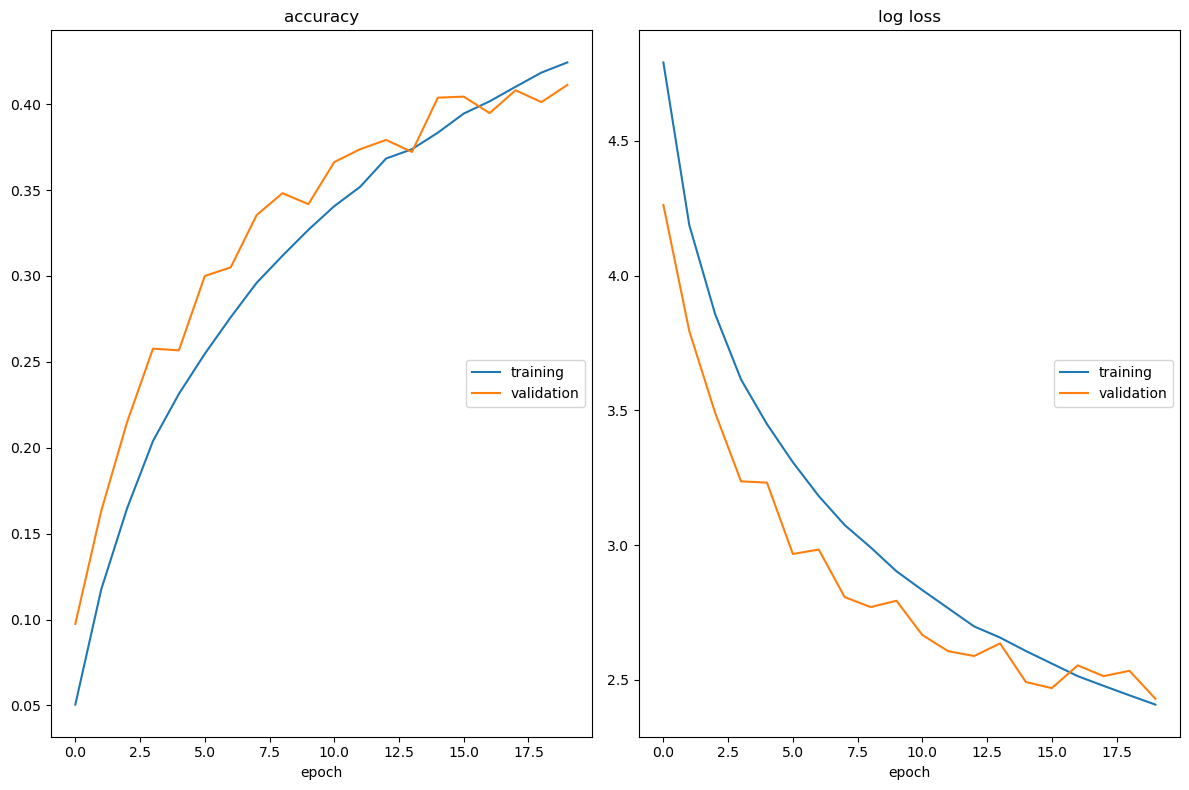

Epoch [20]


In [41]:
train_v0(model, dataloaders, criterion = CRITERION, optimizer = OPTIMIZER, 
         n_epochs = N_EPOCHS, scheduler = SCHEDULER, device = 'mps')

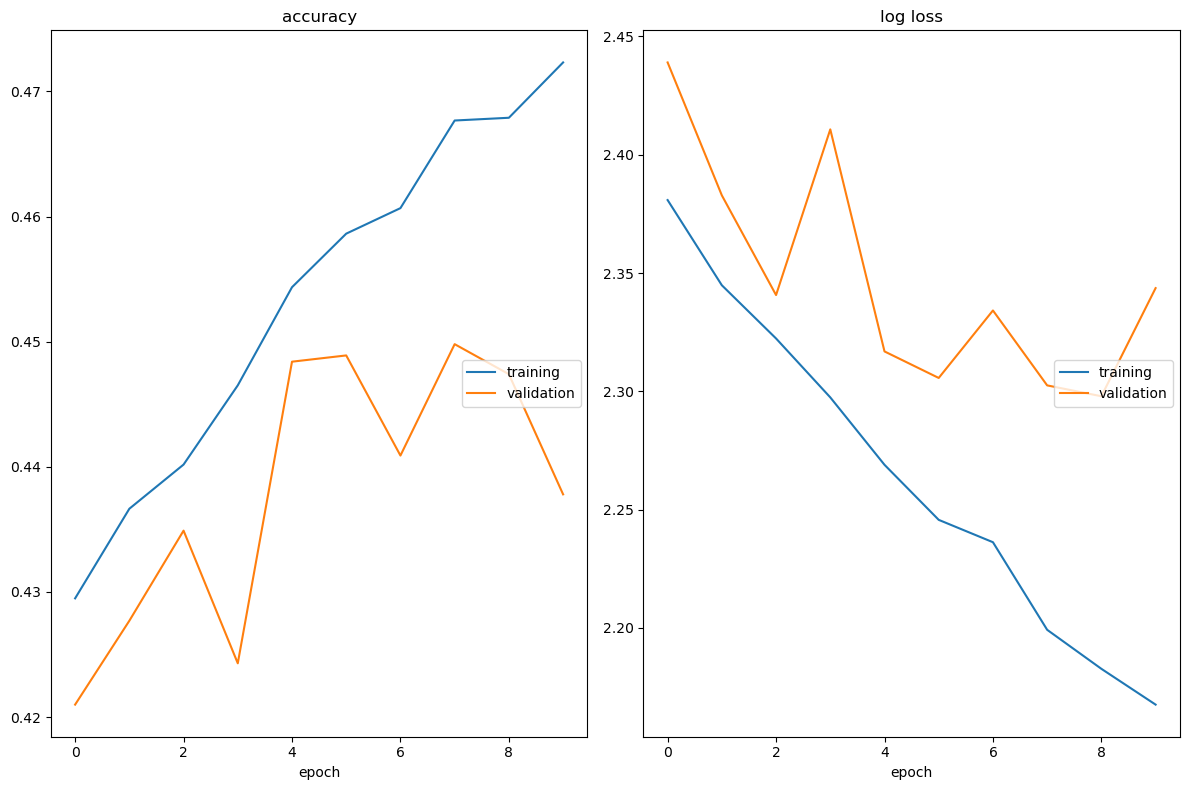

Epoch [10]


In [42]:
# additional 10 epochs
train_v0(model, dataloaders, cri terion = CRITERION, optimizer = OPTIMIZER, 
         n_epochs = 10, scheduler = SCHEDULER, device = 'mps')

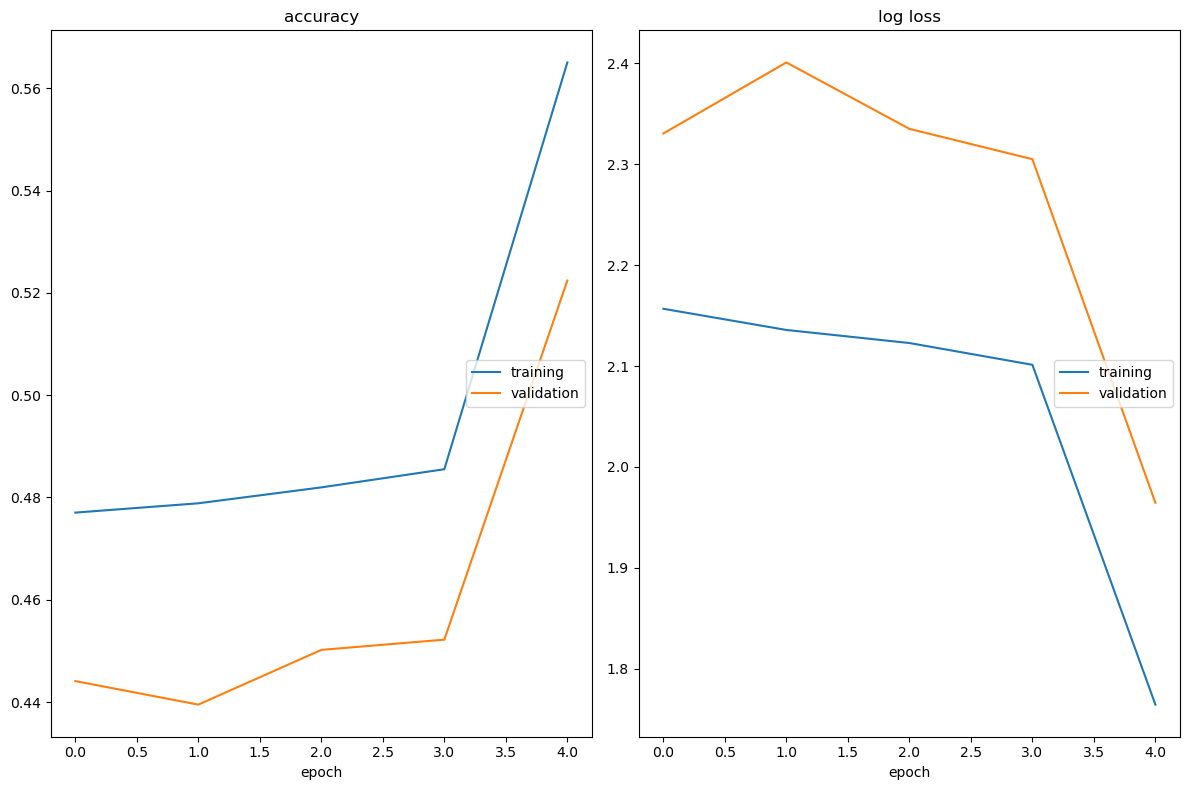

Epoch [5]


In [43]:
# additional 5 epochs
train_v0(model, dataloaders, criterion = CRITERION, optimizer = OPTIMIZER, 
         n_epochs = 5, scheduler = SCHEDULER, device = 'mps')

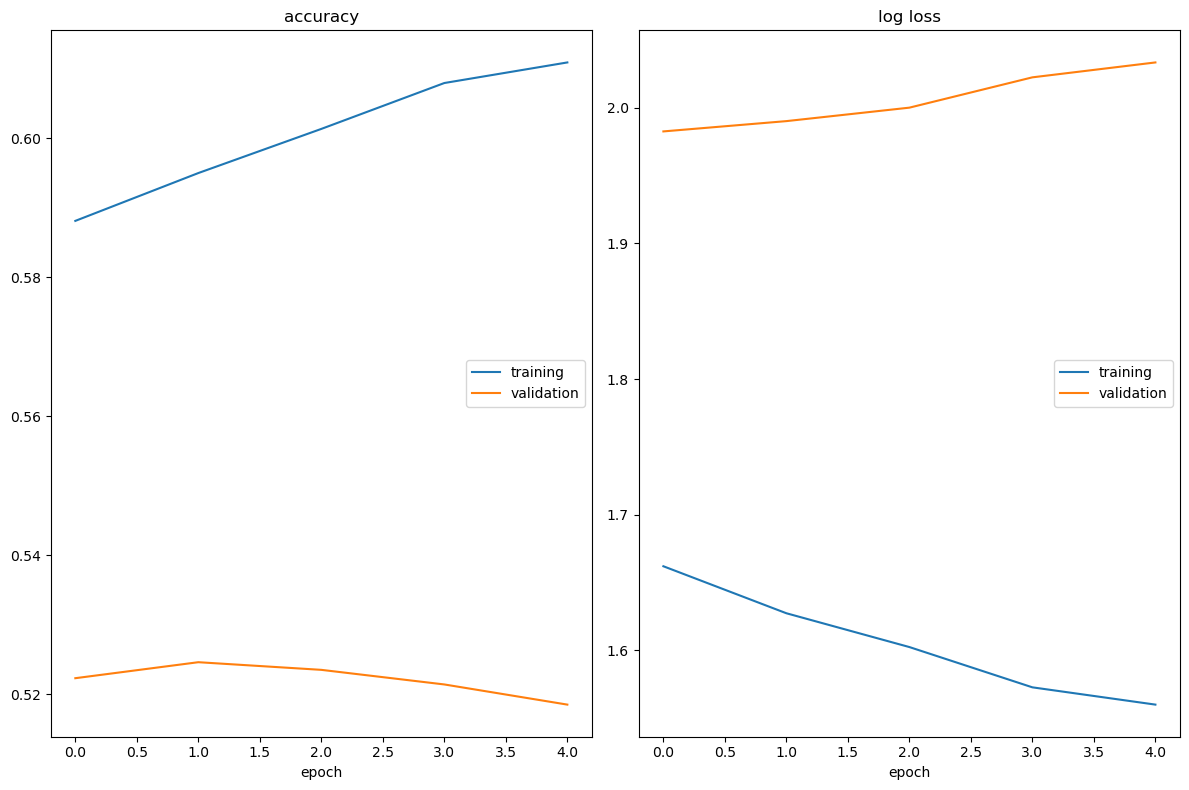

Epoch 00040: reducing learning rate of group 0 to 4.0000e-03.
Epoch [5]


In [44]:
# additional 5 epochs
train_v0(model, dataloaders, criterion = CRITERION, optimizer = OPTIMIZER, 
         n_epochs = 5, scheduler = SCHEDULER, device = 'mps')

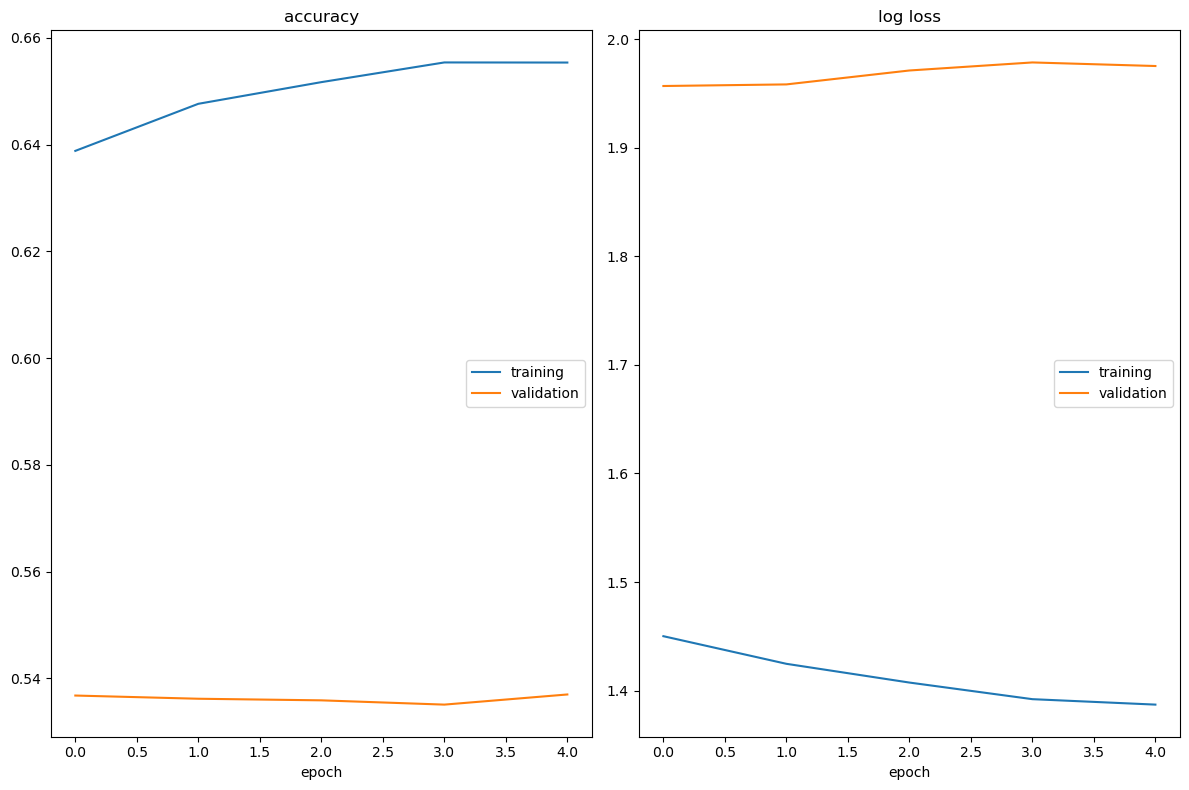

Epoch [5]


In [45]:
# additional 5 epochs
train_v0(model, dataloaders, criterion = CRITERION, optimizer = OPTIMIZER, 
         n_epochs = 5, scheduler = SCHEDULER, device = 'mps')

In [47]:
#save the model 
#torch.save(model, 'DNNModel.pt')

### Final Test

In [49]:
model_load = torch.load('DNNModel.pt')

In [54]:
all_losses, predicted_labels, true_labels = predict(model_load, val_loader, CRITERION, 'mps')
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy {accuracy}')
print("Оценка за это задание составит {} баллов".format(min(5, 5 * accuracy / 0.44)))

Accuracy 0.537
Оценка за это задание составит 5 баллов


### Experiments

Before arriving with this model I tried several experiments

All Models are based on DenseNet

- **_Base Model_**
```
    - DEVICE                     MPS
    - BATCH_SIZE                 256
    - NUM_EPOCHS                 10
    - LEARNING_RATE              0.1
    - OPTIMIZER                  SGD + 10^(-4) decay + 0.9 Nesterov momentum
```
    **DenseNet Specification**
```
    - ACTIVATION                 ReLU
    - GROWTH_RATE                12
    - BLOCKS                     (12, 12, 12)
    - COMPRESSION                0.5
    - BN_SIZE                    4
    - DROPRATE                   0
    - AUGMENTATIONS              NONE
    - PARAMETERS                 538,868
```
    **Results**
```
    - TIME                       --
    - TRAIN LOSS                 2.2
    - TEST ACCURACY              35.75
```


- **Experiment 1:** ReLU --> ELU

    **Results**
```
    - TIME                       --
    - TRAIN LOSS                 2.51
    - TEST ACCURACY              32.095
```

- **Experiment 2:** ReLU --> LeakyReLU with $a = 0.02$
    
        **Results**
```
    - TIME                       1000 sec
    - TRAIN LOSS                 2.2
    - TEST ACCURACY              38.12
```

- **Experiment 3:** LeakyRelu $a = 0.02$ + TrivialAugment

        **Results**
```
    - TIME                       1200 sec
    - TRAIN LOSS                 2.8
    - TEST ACCURACY              36.12
```

- **Experiment 3:** LeakyRelu $a = 0.02$ + BATCH_SIZE = 128

        **Results**
```
    - TIME                       1340 sec
    - TRAIN LOSS                 2.8
    - TEST ACCURACY              37.8
```

- **Experiment 4:** LeakyRelu $ a = 0.02$, Blocks: (6, 12, 24, 6), Dropout 0.2, bn_size 2

        **Results**
```
    - TIME                       1070 sec
    - TRAIN LOSS                 2.4
    - TEST ACCURACY              35.45
```

- **Experiment 5:** LeakyRelu $ a = 0.02$, GROWTH = 16 (911,036 PARAMATERS)

        **Results**
```
    - TIME                       1177 sec
    - TRAIN LOSS                 1.9824
    - TEST ACCURACY              40.03 %
```

- **Experiment 6 (Heavier Model):** LeakyRelu $ a = 0.02$, GROWTH = 21, Block = (6, 12, 24, 16), Dropout = 0.2 (3M PARAMATERS)

        **Results**
```
    - TIME                       3091 sec
    - TRAIN LOSS                 1.5854
    - TEST ACCURACY              38.55 %
```


**Result**
- In the end I just used the specification from experiemnt **5** 
- added TrivialAugment, scheduler on Plateau and Increased number of epochs for training